In [1]:
%pylab inline

from PyTools import nbins
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]
res_lbs = [r"$\Delta_r M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
           r"$\Delta\left<\log{Z_\star}\right>_M$", r"$\Delta\left<\log{Z_\star}\right>_L$",
           r"$\Delta A_V$"]

od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")

In [3]:
#load SDSS catalog
table_obs = genfromtxt("../inputs/total_photometry.txt", dtype=None, names=True)

xcolor_obs = (table_obs["modelMag_u"]-table_obs["modelMag_g"])[table_obs["z"]<0.03]
ycolor_obs = (table_obs["modelMag_g"]-table_obs["modelMag_r"])[table_obs["z"]<0.03]

#load whole SSAG
table = genfromtxt("../inputs/SSAG_catalog.txt", dtype=None, names=True)
table["mwage"] = log10(table["mwage"])

table_lib = zeros(table.shape[0], dtype=table.dtype.descr+[("Av", "<f8")])
for f in table.dtype.names: table_lib[f] = table[f]
table_lib["Av"] = table["V"]-table["pV"]

#load set3 sample
table_set = genfromtxt("../inputs/set3_catalog.txt", dtype=None, names=True)

In [4]:
def perturbation(xo, yo, x, y, R=0.05):
    idxs = arange(x.size, dtype=np.int)
    mask = (xo-x)**2 + (yo-y)**2<=R**2

    index = random.choice(idxs[mask])
    return index

xcolor_lib = table_lib["umag"] - table_lib["gmag"]
ycolor_lib = table_lib["gmag"] - table_lib["rmag"]

xcolor_set = table_set["umag"] - table_set["gmag"]
ycolor_set = table_set["gmag"] - table_set["rmag"]

si = array([argmin(abs(name-table_lib["name"])) for name in table_set["name"]])

In [5]:
labels = [r"$M_\star$", r"$\left<\log{t_\star}\right>_L$", r"$Z_\star/Z\odot$", r"$A_V$"]
limits = [(0, 7), (8, 10.2), (0, 2.5), (0, 5)]
fields = ["mass", "rfwla", "Z", "Av"]
xi, xc, xe = [], [], []
for i in xrange(100):
    ind = array([perturbation(x, y, xcolor_lib, ycolor_lib) for x, y in zip(xcolor_set, ycolor_set)])
    xi.append(ind)
    
    fcounts, fcenter = [], []
    for j in xrange(len(fields)):
        counts, edges = histogram(table_lib[fields[j]][ind], 20, range=limits[j])
        fcounts.append(counts)
        fcenter.append((edges[:-1]+edges[1:])*0.5)
    xc.append(fcounts)

xi = array(xi)
xc = array(xc)
xe = array(fcenter)

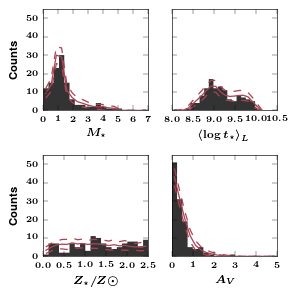

In [6]:
fig, axs = subplots(2, 2, figsize=(3.3, 3.3), sharey=True)
axs = axs.ravel()

mean_counts = xc.mean(axis=0)
sigm_counts = xc.std(axis=0)

for i in xrange(axs.size):
    axs[i].hist(table_lib[fields[i]][si], 20, range=limits[i], lw=0, histtype="stepfilled", color="0.2")
    axs[i].plot(xe[i], mean_counts[i]-sigm_counts[i], "--", color="#AA4455")
    axs[i].plot(xe[i], mean_counts[i]+sigm_counts[i], "--", color="#AA4455")
    axs[i].plot(xe[i], mean_counts[i], "-", color="#AA4455")
    
    axs[i].set_xlabel(labels[i])

ylim(0, 55)
axs[0].set_ylabel(r"\bf Counts")
axs[2].set_ylabel(r"\bf Counts")
tight_layout()
savefig(od + "current_sample_robustness")

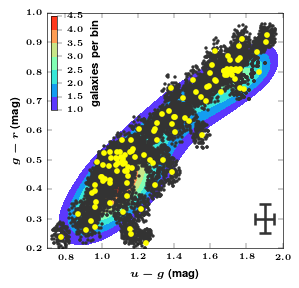

In [7]:
xcolor_cum = append(xcolor_set, xcolor_lib[xi])
ycolor_cum = append(ycolor_set, ycolor_lib[xi])

xlm = array((0.7, 2.0))
ylm = array((0.2, 1.0))
axs = subplot(111, xlim=xlm, ylim=ylm)
ins = inset_axes(axs, width="2.5%", height="40%", loc=2)

axs.set_xlabel(r"\bf $u-g$ (mag)")
axs.set_ylabel(r"\bf $g-r$ (mag)")

nx, xini, xfin, bsx = nbins(xcolor_obs)
ny, yini, yfin, bsy = nbins(ycolor_obs)

H, xedges, yedges = histogram2d(xcolor_obs, ycolor_obs, bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = axs.contourf(xedges[:- 1], yedges[:- 1], H.T, cmap=cm.rainbow, levels=np.arange(1, 5, 0.5))
cb = colorbar(cont, cax=ins)
cb.set_label(r"\bf galaxies per bin")

axs.scatter(xcolor_cum[120:], ycolor_cum[120:], marker="o", lw=0.0, c="0.2", s=7)
axs.scatter(xcolor_cum[:120], ycolor_cum[:120], marker="o", lw=0.0, c="yellow")

axs.errorbar([1.9], [0.3], 0.05, 0.05, color="0.2", ecolor="0.2", capsize=5, lw=2, mew=2)

ins.tick_params(right=True, left=False, direction="out", labelright="on", labelleft="off")
ins.yaxis.set_label_position("right")

savefig("sample_robustness")